# Factorisation de matrices

Auteurs : Slim Essid, Alexandre Gramfort, Joseph Salmon

Pour ce travail vous devez déposer un **UNIQUE** ﬁchier sous format ipynb sous EOLE. Pour
démarrer un ipython notebook sur les machines de l’école, utiliser la version appelée “(Anaconda)”
dans l’onglet “Applications/développement/”. Le nom du ﬁchier uploadé sera OBLIGATOIREMENT
Nom_Prenom_TP_Clustering.ipynb. Vous devrez charger votre ﬁchier sur Éole (SD207 > TPs > TP1),
et ce avant 23h59, le 01/06/2017. La note totale est sur 20 points répartis comme suit :
 - qualité des réponses aux questions : 15 pts,
 - qualité de rédaction, de présentation et d’orthographe : 2 pts,
 - indentation, Style PEP8 (cf. par exemple https://github.com/ipython/ipython/wiki/Extensions-Index#pep8), commentaires adaptés : 2 pts,
 - absence de bug : 1 pt.
Malus : 5 pts par tranche de 12h de retard (sauf excuses validées par l’administration); 2 pts pour non
respect des autres consignes de rendu. La note sera ensuite ramenée sur 3 points dans la note ﬁnale de
l’UE.
**Rappel : aucun travail par mail accepté**

## Réduction de dimension par analyse en composantes principales (PCA)


In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from time import time

Reprenons les images de chiffres manuscrits :

In [3]:
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target

n_samples, n_features = X.shape
n_digits = len(np.unique(y))

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))

n_digits: 10, 	 n_samples 1797, 	 n_features 64


### A faire :
En utilisant sklearn, 
 - afficher la base de données en dimension 2 après réduction de dimension de 64 à 2 avec une PCA ; 
 - colorer les échantillons en fonction des vraies étiquettes ;
 - réaliser un clustering par K-moyennes de la base de données en utilisant les cractéristiques en 2D obtenues par PCA. 
 - comparer au résultat obtenu précédemment sans réduction de dimension.

In [4]:
#X = StandardScaler().fit_transform(X)

# reduce the dimension from 64 to 2 using PCA
pca = PCA(n_components = 2)
X_2D = pca.fit_transform(X)

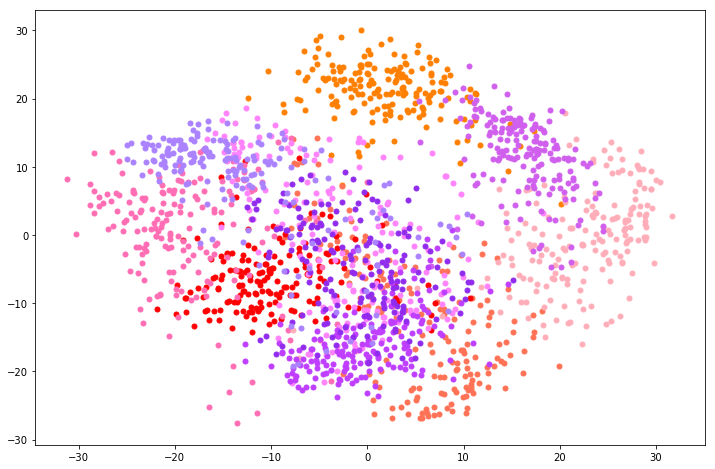

In [5]:
# plot the points with different colors
colors = ["#FF7F00","#FF7256","#FF0000","#FF6EB4","#FFAEB9","#FF83FA","#D15FEE","#BF3EFF","#912CEE","#AB82FF"]
y_uniq = np.unique(y)
plt.figure(1, figsize=(12, 8))
for i in range(n_digits):
    plt.scatter(X_2D[y == y_uniq[i], 0], X_2D[y == y_uniq[i], 1], c = colors[i], s = 25)   
plt.show()

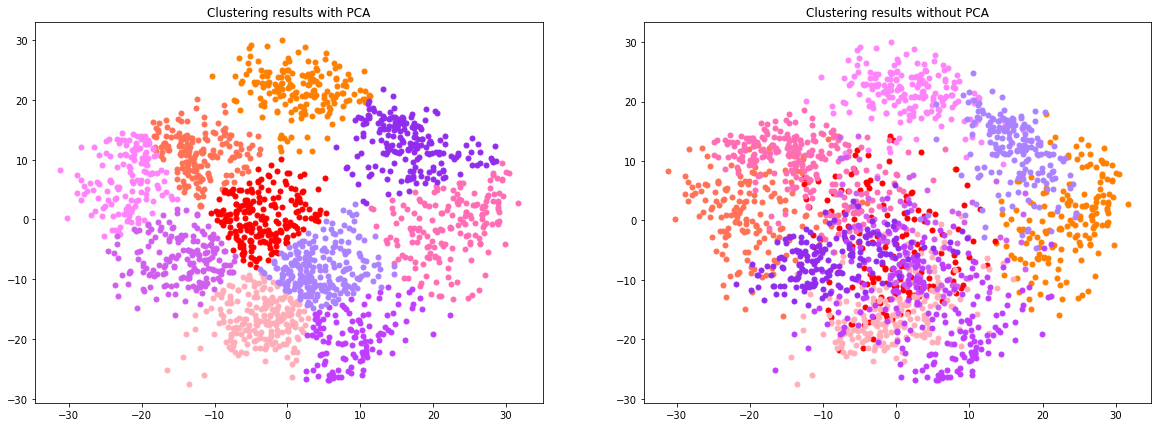

In [6]:
plt.figure(2, figsize=(20, 7))

# clustering with PCA
kmeans = KMeans(n_clusters=len(np.unique(y)), random_state=0).fit(X_2D)
y_pred_2D = kmeans.labels_

plt.subplot(121)
for i in range(len(y_uniq)):
    plt.scatter(X_2D[y_pred_2D == y_uniq[i], 0], X_2D[y_pred_2D == y_uniq[i], 1], c = colors[i], s = 25) 
plt.title("Clustering results with PCA")

# clustering without PCA
kmeans = KMeans(n_clusters=len(np.unique(y)), random_state=0).fit(X)
y_pred_full = kmeans.labels_

plt.subplot(122)
for i in range(len(y_uniq)):
    plt.scatter(X_2D[y_pred_full == y_uniq[i], 0], X_2D[y_pred_full == y_uniq[i], 1], c = colors[i], s = 25)     
plt.title("Clustering results without PCA")

plt.show()

## Extraction de caractéristiques faciales

On envisage ici l'utilisation des techniques de décomposition par PCA et NMF pour l'extraction de caractéristiques utiles à la reconnaissance automatique de visages.

 - Étudier et tester le script ci-dessous. 

 - Analyser le type de décomposition obtenu par NMF en comparaison avec celui obtenu par PCA. 


In [7]:
from time import time
from numpy.random import RandomState

from sklearn.datasets import fetch_olivetti_faces
from sklearn import decomposition
from sklearn.lda import LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

/Users/rui/anaconda/lib/python2.7/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


On commence par préparer les données et définir quelques fonctions utilitaires :

64
Dataset consists of 1797 faces
2061 negative-valued pixels


/Users/rui/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:3316: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


2773 negative-valued pixels
2630 negative-valued pixels
1422 negative-valued pixels
1242 negative-valued pixels
1004 negative-valued pixels
2049 negative-valued pixels
1580 negative-valued pixels
1387 negative-valued pixels
3819 negative-valued pixels


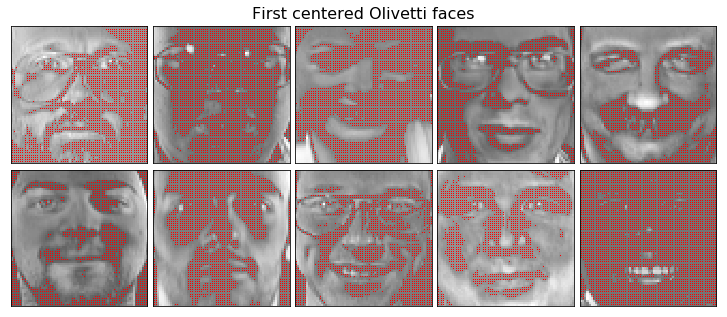

In [8]:
# -- Prepare data and define utility functions 

n_row, n_col = 2, 5
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# Load faces data
dataset = fetch_olivetti_faces(data_home='c:/tmp/',shuffle=True,
                               random_state=rng)
faces = dataset.data

l = faces.shape
print n_features

# global centering
faces_centered = faces - faces.mean(axis=0, dtype=np.float64)

print "Dataset consists of %d faces" % n_samples

def plot_gallery(title, images):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)

        comp = comp.reshape(image_shape)
        vmax = comp.max()
        vmin = comp.min()
        dmy = np.nonzero(comp<0)
        if len(dmy[0])>0:
            yz, xz = dmy
        comp[comp<0] = 0

        plt.imshow(comp, cmap=plt.cm.gray, vmax=vmax, vmin=vmin)

        if len(dmy[0])>0:
            plt.plot( xz, yz, 'r,', hold=True)
            print len(dmy[0]), "negative-valued pixels"

        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# Plot a sample of the input data
plot_gallery("First centered Olivetti faces",
             faces_centered[:n_components])


On définit les méthodes à tester et leur paramétrisation, à compéter par vos soins :

In [9]:
# -- Decomposition methods 

# List of the different estimators and whether to center the data

estimators = [
    ('pca', 'Eigenfaces - PCA',
     decomposition.PCA(n_components = n_components),
     True),

    ('nmf', 'Non-negative components - NMF',
     decomposition.NMF(n_components = n_components),
     False)
]


Et on applique à la base de données d'images :

Extracting the top 10 Eigenfaces - PCA...
done in 0.112s
3998 negative-valued pixels
2078 negative-valued pixels
1967 negative-valued pixels
1862 negative-valued pixels
2261 negative-valued pixels
1924 negative-valued pixels
1951 negative-valued pixels
1884 negative-valued pixels
2221 negative-valued pixels
2128 negative-valued pixels
Extracting the top 10 Non-negative components - NMF...
done in 3.086s


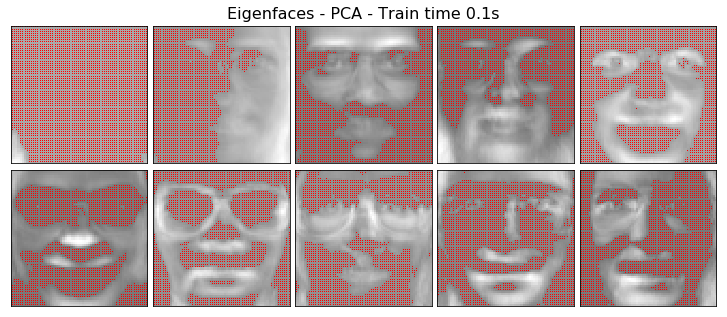

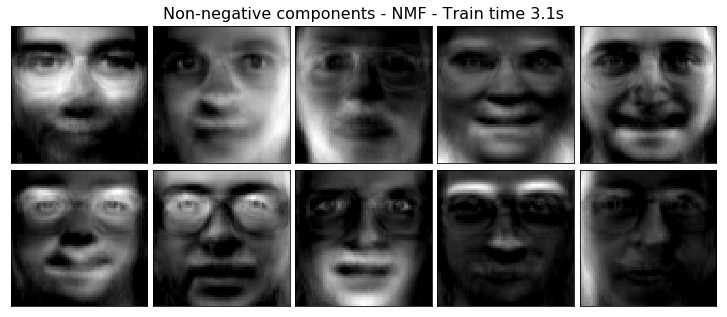

In [10]:
# -- Transform

labels = dataset.target
X = faces
X_ = faces_centered

for shortname, name, estimator, center in estimators:
    #if shortname != 'nmf': continue
    print "Extracting the top %d %s..." % (n_components, name)
    t0 = time()

    data = X
    if center:
        data = X_

    data = estimator.fit_transform(data)

    train_time = (time() - t0)
    print "done in %0.3fs" % train_time

    components_ = estimator.components_

    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])


### A faire 

Modifier le script pour réaliser une évaluation des performances d'un système de reconnaissance automatique de visages utilisant les caractéristiques extraites par PCA, comparées à celles obtenues par un système exploitant les caractéristiques extraites par NMF. On pourra utiliser la LDA ou la régression logistique our la classification. On effectuera l'évaluation par validation croisée. On observera l'évolution des scores en faisant varier le nombre de composantes utilisé dans les décompositions.


In [11]:
y = dataset.target
from sklearn import linear_model

# PCA
scores_pca = []
scores_pcaU = []
scores_pcaD = []
timePCA = 0

# NMF
scores_nmf = []
scores_nmfU = []
scores_nmfD = []
timeNMF = 0

for i in range(4,305, 4):
    print "n_components = %d" %(i)
    # PCA
    time1 = time()
    pca = decomposition.PCA(n_components = i)
    faces_pca = pca.fit_transform(faces_centered)
    timePCA = timePCA + time()-time1
    clf = linear_model.LogisticRegression()
    scoresCV = cross_val_score(clf, faces_pca, y, cv = 5)
    scores_pca.append(scoresCV.mean())
    scores_pcaU.append(scoresCV.mean() + scoresCV.std() * 2)
    scores_pcaD.append(scoresCV.mean() - scoresCV.std() * 2)
    # NMF
    time2 = time()
    nmf = decomposition.NMF(n_components = i)
    faces_nmf = nmf.fit_transform(faces)
    timePCA = timePCA + time()-time2
    clf = linear_model.LogisticRegression()
    scoresCV = cross_val_score(clf, faces_nmf, y, cv = 5)
    scores_nmf.append(scoresCV.mean())
    scores_nmfU.append(scoresCV.mean() + scoresCV.std() * 2)
    scores_nmfD.append(scoresCV.mean() - scoresCV.std() * 2)

n_components = 4
n_components = 8
n_components = 12
n_components = 16
n_components = 20
n_components = 24
n_components = 28
n_components = 32
n_components = 36
n_components = 40
n_components = 44
n_components = 48
n_components = 52
n_components = 56
n_components = 60
n_components = 64
n_components = 68
n_components = 72
n_components = 76
n_components = 80
n_components = 84
n_components = 88
n_components = 92
n_components = 96
n_components = 100
n_components = 104
n_components = 108
n_components = 112
n_components = 116
n_components = 120
n_components = 124
n_components = 128
n_components = 132
n_components = 136
n_components = 140
n_components = 144
n_components = 148
n_components = 152
n_components = 156
n_components = 160
n_components = 164
n_components = 168
n_components = 172
n_components = 176
n_components = 180
n_components = 184
n_components = 188
n_components = 192
n_components = 196
n_components = 200
n_components = 204
n_components = 208
n_components = 212
n_components = 216


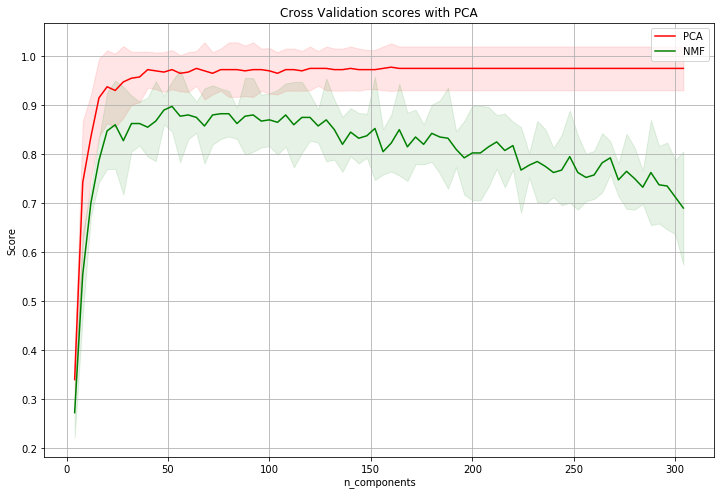

In [12]:
plt.figure(3, figsize=(12, 8))
plt.title("Cross Validation scores with PCA")
plt.xlabel("n_components")
plt.ylabel("Score")
plt.grid()
plt.fill_between(range(4,305, 4), scores_pcaD, scores_pcaU, alpha=0.1, color="r")
plt.fill_between(range(4,305, 4), scores_nmfD, scores_nmfU, alpha=0.1, color="g")
plt.plot(range(4,305, 4), scores_pca, '-', color="r", label = "PCA")
plt.plot(range(4,305, 4), scores_nmf, '-', color="g", label = "NMF")
plt.legend(loc="best")

Comme on peut voir au-dessus, le score de NMF décoît quand le n_components augmente, mais celui de PCA se stabilise.

## Extraction de thèmes à partir de textes

Il s'agit dans cette partie de tester l'utilisation de la NMF pour l'extraction de thèmes à partir d'un corpus de textes ; l'idée principale étant d'interpréter chaque composante NMF extraite comme étant associée à un thème.

Étudier et tester le script suivant :

In [15]:
from sklearn.feature_extraction import text
from time import time

On commence par définir quelques paramètres d'expérience : 

In [16]:
n_samples = 1000
n_features = 900
n_topics = 4
n_top_words = 20

 On charge les textes de certaines catégories du corpus [20newsgroups](http://qwone.com/~jason/20Newsgroups/) :

In [17]:
from sklearn import datasets
# Load the 20 newsgroups dataset 

t0 = time()

# Load some categories from the training set
categories = ['rec.sport.baseball','comp.graphics', 'comp.sys.mac.hardware',
              'talk.religion.misc']

print "Loading dataset..."
dataset = datasets.fetch_20newsgroups(data_home='c:/data/text/', shuffle=True,
                                      categories=categories, random_state=1)

print "done in %0.3fs." % (time() - t0)

Loading dataset...
done in 0.861s.


In [18]:
print len(dataset.data)

2136


On représente chaque document par sa [TF-IDF](https://fr.wikipedia.org/wiki/TF-IDF) : 

In [19]:
# vectorize data using the most common word
# frequency with TF-IDF weighting (without top 5% stop words)

print "Extracting TF-IDF features..."
t0 = time()
vectorizer = text.CountVectorizer(max_df=0.95, max_features=n_features, stop_words='english')
counts = vectorizer.fit_transform(dataset.data[:n_samples])
tfidf = text.TfidfTransformer().fit_transform(counts)
print "done in %0.3fs." % (time() - t0)

Extracting TF-IDF features...
done in 0.268s.


In [20]:
print type(counts)
print tfidf.shape

<class 'scipy.sparse.csr.csr_matrix'>
(1000, 900)


On applique la NMF :

In [21]:
# Fit the NMF model
print "Fitting the NMF model with n_samples=%d and n_features=%d..." % (
    n_samples, n_features)

t0 = time()
nmf = decomposition.NMF(n_components=n_topics).fit(tfidf)
print "done in %0.3fs." % (time() - t0)



Fitting the NMF model with n_samples=1000 and n_features=900...
done in 0.091s.


Et on interprète les "vecteurs de base" comme des thèmes :

In [22]:
# Inverse the vectorizer vocabulary to be able
feature_names = vectorizer.get_feature_names()

for topic_idx, topic in enumerate(nmf.components_):
    print "Topic #%d:" % topic_idx
    print " ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]])

Topic #0:
edu year article team baseball cs players writes game university runs host nntp posting jewish good hit season games win
Topic #1:
graphics files file uk thanks ac 3d program package help ca image windows university computer need format posting use com
Topic #2:
com god jesus sandvik people christian writes bible don kent christians brian netcom koresh article life said newton just apple
Topic #3:
mac apple edu drive scsi quadra monitor problem video centris duo se problems card power drives software internal disk ram


La NMF permet donc de réaliser du clustering "doux" de documents : chaque document peut être associé à plusieurs thèmes à la fois.

## A faire

Reproduire l'expérience précédente en utilisant des GMM et en interprétant les thèmes à partir des centroïdes de chaque cluster.
 - Comparer le résultat obtenu au résultat NMF.
 - En interprétant les thèmes au travers des mots clés les plus représentatifs, repérer les thèmes pour lesquels les deux méthodes (NMF et GMM) semblent réaliser un consensus.
 - En étiquettant chaque document par les 3 thèmes les plus pertinents, avec les deux approches, proposer une méthode qui permette de caractériser le "taux d'accord" de ces deux approches quant à l'étiquetage des documents. Calculer ce "taux d'accord".

In [52]:
from sklearn import mixture

print "Fitting the GMM model with n_samples=%d and n_features=%d..." % (
    n_samples, n_features)

t0 = time()
gmm = mixture.GaussianMixture(n_components=4, random_state = 30).fit(tfidf.toarray())
print "done in %0.3fs." % (time() - t0)

Fitting the GMM model with n_samples=1000 and n_features=900...
done in 1.205s.


In [53]:
for topic_idx2, topic2 in enumerate(gmm.means_):
    print "Topic #%d: " % topic_idx2
    print " ".join([feature_names[i]
                    for i in topic2.argsort()[:-n_top_words - 1:-1]])

Topic #0: 
god jesus com people sandvik christian edu morality koresh bible writes christians don said article kent say hudson objective law
Topic #1: 
com mac apple edu drive quadra monitor scsi video problem duo centris card posting netcom does article know nntp host
Topic #2: 
edu article year team baseball writes university players cs game posting host nntp com cleveland jewish good runs just don
Topic #3: 
graphics edu thanks uk university files file ac posting help nntp host computer program image 3d ca need use know


En suite, on va repérer les thèmes pour lesquels les deux méthodes semblent réaliser un consensus en comparantant la distance Euclidienne entre les vecteurs de base de NMF et les centroïdes de chaque cluster de GMM.

In [54]:
from sklearn.preprocessing import normalize

nmfbase = normalize(nmf.components_)
gmmcent = normalize(gmm.means_)

dist = np.ones((n_topics,n_topics))
for i in range(n_topics):
    for j in range(n_topics):
        dist[i,j] = np.sum((nmfbase[i,:]-gmmcent[j,:])**2)

In [55]:
ord_topic = np.argmin(dist, axis = 1)

gmmmeans = gmm.means_[ord_topic, :]
print "Next we compare the results obtained by the two methods after matching them respectively."
print "The results of NMF:"
for topic_idx, topic in enumerate(nmf.components_):
    print "Topic #%d:" % topic_idx
    print " ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]])
print "The results of GMM:"
for topic_idx2, topic2 in enumerate(gmmmeans):
    print "Topic #%d: " % topic_idx2
    print " ".join([feature_names[i]
                    for i in topic2.argsort()[:-n_top_words - 1:-1]])

Next we compare the results obtained by the two methods after match them respectively.
The results of NMF:
Topic #0:
edu year article team baseball cs players writes game university runs host nntp posting jewish good hit season games win
Topic #1:
graphics files file uk thanks ac 3d program package help ca image windows university computer need format posting use com
Topic #2:
com god jesus sandvik people christian writes bible don kent christians brian netcom koresh article life said newton just apple
Topic #3:
mac apple edu drive scsi quadra monitor problem video centris duo se problems card power drives software internal disk ram
The results of GMM:
Topic #0: 
edu article year team baseball writes university players cs game posting host nntp com cleveland jewish good runs just don
Topic #1: 
graphics edu thanks uk university files file ac posting help nntp host computer program image 3d ca need use know
Topic #2: 
god jesus com people sandvik christian edu morality koresh bible writ

En suite, on calcule le "taux d'accord".
<p>Pour NMF, on va d'abords obtenir le data transformé par NMF et puis pour chaque sample, choisir les trois components qui ont les plus grandes valeurs dans le data transformé comme les trois thèmes le plus pertinents.
</p>

In [56]:
nmftransform = nmf.transform(tfidf)
labelNMF = np.ones_like(nmftransform, dtype = bool)
idx = np.argmin(nmftransform, axis = 1)
labelNMF[np.arange(nmftransform.shape[0]),idx] = False
#print labelNMF

Pour GMM, l'intuition, c'est d'obtenir les probabilités postérieures de données par chaque composant prédite par GMM, respectivement, comme dans le cas de NMF. Mais c'est pas faisable en pratique comme on peut voir dessous:

In [57]:
gmmppredict = gmm.predict_proba(tfidf.toarray())
print "posterior probability of data per each component predicted by GMM"
print gmmppredict[:5,:]

posterior probability of data per each component predicted by GMM
[[ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]]


Donc, on calcule la distance entre chaque sample et les centroïdes et choisi les trois centroïdes les plus proches.

In [60]:
labelGMM = np.ones_like(gmmppredict, dtype = bool)
tfidfarr = tfidf.toarray()
dist = [[np.sum((tfidfarr[i]-gmm.means_[j])**2) for j in range(n_topics)] for i in range(n_samples)]
idx = np.argmax(dist, axis = 1)
labelGMM[np.arange(nmftransform.shape[0]),idx] = False
#print labelGMM

Alors, on calcule le "taux d'accord" comme le moyen de nombres d'étiquettes différentes de ces deux méthodes.

In [62]:
# match the similar topic
labelGMM = labelGMM[:,ord_topic]
# calculate "taux d'accord"
taux = 1 - np.mean(labelNMF != labelGMM)/3
print "taux d'accord : %f" %(taux)

taux d'accord : 0.880500
